In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pyfolio as pf
import quantstats
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
import sys
from scipy.stats import rankdata
from scipy.stats import stats
from scipy.optimize import minimize

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


종목의 포트폴리오에 대한 위험 기여도(Risk Contribution)는 개별 종목 비중과 그 종목의 한계 위험 기여도(Marginal Risk Contribution)의 곱으로 나타납니다. 한계 위험 기여도는 종목 비중 1단위 증가 시 포트폴리오 변동성 증가량을 의미합니다. 위험 균형(Risk Parity) 전략은 포트폴리오 내 종목들의 위험 기여도가 같도록 하는 것이 목적입니다. 위험 기여도 계산을 위해서는 과거 수익률 데이터와 수익률 데이터의 공분산 행렬이 필요합니다. Bridgewater Associates의 All Weather 전략에서 사용하는 자산군이 주식, 국채, TIPS, 금, 회사채, 원자재 정도이므로 미국 주식, 선진국 주식, 신흥국 주식, 미국 10년물 국채, 미국 30년물 국채, 미국 회사채, 미국 물가채, 금, 원자재 데이터를 사용합니다. 장기 월간 데이터로 먼저 구성한 후, 실제 사용 가능한 ETF들로 더 세분화해서 구성해 보겠습니다.

In [2]:
Monthly_Return = pd.read_excel('MonthlyAssetClassReturn.xlsx')
Monthly_Return.head()

,Data Index,Broker Call Rate,CPI,T-Bills,S&P 500 Total return,Small Cap Stocks,MSCI EAFE,EEM,US 10 YR,US Corp Bond Return Index,...,International Small Cap Value (Global B/M Small Low),International Large Cap Value (Global B/M Big Low),International Small High Mom (Global mom Small High),International Large High Mom (Global mom Small High),Merrill High Yield,World Stocks,World ex USA,BuyWrite,PutWrite,Bitcoin
0,1900-01-31,NaN,0.013333,0.0025,0.016413,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-02-28,NaN,0.000000,0.0025,0.021138,NaN,NaN,NaN,0.011278,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-03-31,NaN,0.000000,0.0025,0.011084,NaN,NaN,NaN,0.009758,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-04-30,NaN,0.000000,0.0025,0.015894,NaN,NaN,NaN,-0.016107,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-05-31,NaN,0.000000,0.0025,-0.044246,NaN,NaN,NaN,0.016023,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
Monthly_Return = Monthly_Return.set_index('Data Index')
Mon_Return = Monthly_Return.loc[:, ['S&P 500 Total return','MSCI EAFE','EEM','US 10 YR','US 30 YR','US Corp Bond Return Index','TIPS Series','GOLD','GSCI']]
Mon_Return = Mon_Return.loc[Mon_Return.index >= '1973-02-28']
Mon_Return.head()

,S&P 500 Total return,MSCI EAFE,EEM,US 10 YR,US 30 YR,US Corp Bond Return Index,TIPS Series,GOLD,GSCI
Data Index,,,,,,,,,
1973-02-28,-0.035212,0.082721,0.261974,-0.001738,-0.129261,0.000048,0.002414,0.286576,0.043358
1973-03-31,0.000931,0.006339,-0.037417,-0.000927,0.004451,0.005169,-0.003227,0.058617,-0.023813
1973-04-30,-0.038394,-0.055983,-0.113834,0.007770,0.012236,0.006708,0.009247,0.007752,0.060363
1973-05-31,-0.016374,0.024366,0.043714,-0.010804,0.001834,0.005844,-0.003327,0.263736,0.182372
1973-06-30,-0.004016,0.024791,0.011188,0.005058,-0.019592,0.003897,0.004130,0.073913,-0.016939


공분산 행렬을 구합니다.

In [4]:
covmat = pd.DataFrame.cov(Mon_Return)
covmat

,S&P 500 Total return,MSCI EAFE,EEM,US 10 YR,US 30 YR,US Corp Bond Return Index,TIPS Series,GOLD,GSCI
S&P 500 Total return,0.001974,1.449954e-03,0.001495,4.382106e-05,0.000048,0.000268,0.000112,-0.000011,0.000426
MSCI EAFE,0.001450,2.440376e-03,0.001963,-8.664340e-07,-0.000072,0.000255,0.000138,0.000507,0.000660
EEM,0.001495,1.963353e-03,0.003817,-1.482382e-04,-0.000296,0.000234,0.000094,0.000506,0.000890
US 10 YR,0.000044,-8.664340e-07,-0.000148,5.535041e-04,0.000772,0.000299,0.000324,0.000078,-0.000205
US 30 YR,0.000048,-7.168022e-05,-0.000296,7.716103e-04,0.001387,0.000440,0.000418,0.000025,-0.000418
US Corp Bond Return Index,0.000268,2.553661e-04,0.000234,2.993841e-04,0.000440,0.000343,0.000222,0.000082,0.000014
TIPS Series,0.000112,1.378930e-04,0.000094,3.235982e-04,0.000418,0.000222,0.000305,0.000171,0.000099
GOLD,-0.000011,5.066890e-04,0.000506,7.824909e-05,0.000025,0.000082,0.000171,0.003346,0.000799
GSCI,0.000426,6.601547e-04,0.000890,-2.049167e-04,-0.000418,0.000014,0.000099,0.000799,0.003638


비중과 공분산 행렬을 주면 위험 기여도를 (Risk Contribution) 구해주는 함수입니다.

In [5]:
def RC(weight, covmat) :
    weight = np.array(weight)
    # @: 행렬곱
    variance = weight.T @ covmat @ weight
    sigma = variance ** 0.5
    mrc = 1/sigma * (covmat @ weight)
    rc = weight * mrc
    rc = rc / rc.sum()
    return(rc)

가중치 x를 주면 위험 균형(Risk Parity)을 맞추기 위해서 각 자산별 위험 기여도 차이의 제곱합으로 쓰여지는 목적함수를 계산하고, 이론상으로 원하는 값인 0에 가까워지도록 최적화할 것입니다.

In [8]:
def RiskParityObjective(x) :
    
    variance = x.T @ covmat @ x
    sigma = variance ** 0.5
    mrc = 1/sigma * (covmat @ x)
    rc = x * mrc
    a = np.reshape(rc.to_numpy(), (len(rc), 1))
    # 각 자산의 위험 기여도가 같도록
    # 아래쪽의 목적함수가 위험 기여도 차이의 제곱의 합이니 그것이 0에 가깝게 가야 함
    risk_diffs = a - a.T
    # np.ravel: 다차원 배열 -> 1차원 배열
    # 1차원으로 풀어준 후에 제곱 -> 합 -> 목적함수
    sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
    return (sum_risk_diffs_squared)

레버리지가 없고, 공매도를 하지 않으며, 항상 보유 자금 전액 투자하는 것으로 가정하여 종목별 비중 합이 1이고, 각 종목 비중이 0 이상이라고 가정합니다. 나중에 레버리지와 공매도도 사용하고 일부 현금을 남기기도 하는 방식도 만들어 보겠습니다.

In [12]:
# 제약 조건: 비중 합 1
def SumConstraint(x):
    return (x.sum()-1.0)

# 제약 조건: 비중 0 이상
def LongOnly(x):
    return(x)

실제 최적화하는 부분입니다. 초기 비중, 제약 조건, 반복 횟수 등을 설정합니다.

In [13]:
def RiskParity(covmat) :
    
    x0 = np.repeat(1/covmat.shape[1], covmat.shape[1]) 
    constraints = ({'type': 'eq', 'fun': SumConstraint},
                  {'type': 'ineq', 'fun': LongOnly})
    options = {'ftol': 1e-20, 'maxiter': 2000}
    
    result = minimize(fun = RiskParityObjective,
                      x0 = x0,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options)
    return(result.x)

위험 균형을 맞춘 가중치입니다. 미국 주식 8.57%, 선진국 주식 7.07%, 신흥국 주식 6.49%로 합 22.13%, 미국 10년물 국채 15.75%, 미국 30년물 국채 11.23%, 미국 회사채 16.12%, 미국 TIPS 17.45%로 채권류 60.55%, 금 8.54%, 원자재 8.78%가 나옵니다. 1973년 2월부터 2020년 12월까지 전체 기간에 대한 Risk Parity를 만족하는 비중이니, 실제 사용 용도로는 Risk Parity를 계산하는 특정 기간이 있어야 할 것이고, 그 기간에 대하여 비중을 구하고 계속 바꾸어야 합니다.

In [14]:
RiskParity(covmat)

array([0.08568781, 0.07065772, 0.06493921, 0.1574744 , 0.11231389,
       0.16124245, 0.17451293, 0.08540713, 0.08776447])

Risk Contribution이 모두 균일하게 되었습니다. 

In [15]:
weight_rp = RiskParity(covmat)
RC(weight_rp, covmat)

S&P 500 Total return         0.111111
MSCI EAFE                    0.111111
EEM                          0.111111
US 10 YR                     0.111111
US 30 YR                     0.111111
US Corp Bond Return Index    0.111111
TIPS Series                  0.111111
GOLD                         0.111111
GSCI                         0.111111
dtype: float64

동일 가중으로 했을 때는 Risk Contribution이 주식, 금, 원자재에 집중되고, 변동성이 낮았던 채권 쪽에서는 Risk Contribution이 낮습니다. 동일 가중으로 만든 전략은 주식 30%, 국채 20%, 회사채 10%, 물가채 10%, 금 10%, 원자재 10%라는 언뜻 보기에는 괜찮은 비중입니다. 그러나, 실상은 주식과 원자재에 의해 좌우되는 전략입니다.

In [16]:
weight_equal = np.repeat(1/Mon_Return.shape[1], Mon_Return.shape[1])
rc_equal = RC(weight_equal, covmat)

rc_equal

S&P 500 Total return         0.141023
MSCI EAFE                    0.178296
EEM                          0.207808
US 10 YR                     0.041680
US 30 YR                     0.055953
US Corp Bond Return Index    0.052443
TIPS Series                  0.045752
GOLD                         0.133649
GSCI                         0.143396
dtype: float64

전통의 자산배분 전략인 60:40은 주식이 88%의 위험을 담당합니다. 주식 100%보다는 하락장에서 방어가 된다고 하지만, 사실상 주식 전략입니다.

In [18]:
covmat_6040 = pd.DataFrame.cov(Mon_Return[['S&P 500 Total return', 'US 10 YR']])
weight_6040 = np.array([0.6, 0.4])
rc_6040 = RC(weight_6040, covmat_6040)

rc_6040

S&P 500 Total return    0.879188
US 10 YR                0.120812
dtype: float64

이제 실제 사용 용도로 기간별로 Risk Parity를 맞춘 비중을 구해 보겠습니다. 직전 12개월의 데이터로 Risk Parity를 맞추는 것으로 가정합니다.

In [26]:
RP_Mon_12 = Mon_Return
RP_Weight = []

for i in range(len(RP_Mon_12)):
    # use previous 12 months
    print(i)
    if i < 12:
        RP_Weight.append('')
    else:
        covmat = pd.DataFrame.cov(RP_Mon_12.iloc[i-12 : i-1])
        temp = []
        temp.append(RiskParity(covmat))
        RP_Weight.append(temp)

RP_Mon_12['RP_Weight'] = RP_Weight    
RP_Mon_12

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,S&P 500 Total return,MSCI EAFE,EEM,US 10 YR,US 30 YR,US Corp Bond Return Index,TIPS Series,GOLD,GSCI,RP_Weight
Data Index,,,,,,,,,,
1973-02-28,-0.035212,0.082721,0.261974,-0.001738,-0.129261,0.000048,0.002414,0.286576,0.043358,
1973-03-31,0.000931,0.006339,-0.037417,-0.000927,0.004451,0.005169,-0.003227,0.058617,-0.023813,
1973-04-30,-0.038394,-0.055983,-0.113834,0.007770,0.012236,0.006708,0.009247,0.007752,0.060363,
1973-05-31,-0.016374,0.024366,0.043714,-0.010804,0.001834,0.005844,-0.003327,0.263736,0.182372,
1973-06-30,-0.004016,0.024791,0.011188,0.005058,-0.019592,0.003897,0.004130,0.073913,-0.016939,
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.071880,0.051539,0.022350,-0.015141,-0.063811,-0.016749,0.008899,-0.003373,0.045855,"[[0.05172668326045804, 0.0671069801855066, 0.0..."
2020-09-30,-0.037997,-0.025543,-0.015807,0.003377,0.008158,-0.002266,-0.003780,-0.041966,-0.036394,"[[0.042771887479128946, 0.06617528604281964, 0..."
2020-10-30,-0.026593,-0.039822,0.020757,-0.016822,-0.041348,-0.003037,-0.010039,-0.003972,-0.035747,"[[0.04458310762304897, 0.06315774927849194, 0...."


Risk Parity를 맞춘 비중이 구해지는 기간만 남깁니다. 1974년 2월부터입니다.

In [31]:
RP_Mon_12 = RP_Mon_12.loc[RP_Mon_12.index >= '1974-02-28']
RP_Mon_12

,S&P 500 Total return,MSCI EAFE,EEM,US 10 YR,US 30 YR,US Corp Bond Return Index,TIPS Series,GOLD,GSCI,RP_Weight
Data Index,,,,,,,,,,
1974-02-28,-0.000652,0.033312,0.041019,0.005127,-0.008417,0.010417,0.004156,0.225904,-0.005311,"[[0.0713116312808524, 0.04055938332052815, 0.0..."
1974-03-31,-0.020301,-0.025757,-0.029591,-0.021909,-0.004631,-0.014738,-0.011707,0.064496,-0.115087,"[[0.04147101098293171, 0.03291792139630888, 0...."
1974-04-30,-0.035944,0.026993,-0.084748,-0.011155,-0.031023,-0.019728,0.000490,-0.021927,0.011066,"[[0.032531867437622985, 0.025352179436238673, ..."
1974-05-31,-0.030322,-0.038878,0.012152,0.016212,-0.019864,-0.006242,0.027536,-0.073746,-0.067649,"[[0.06551465668791748, 0.04688113790795395, 0...."
1974-06-30,-0.011324,-0.045129,0.029658,-0.002083,0.002104,-0.008441,0.008234,-0.079618,0.124165,"[[0.05997559825465769, 0.07049400910226089, 0...."
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.071880,0.051539,0.022350,-0.015141,-0.063811,-0.016749,0.008899,-0.003373,0.045855,"[[0.05172668326045804, 0.0671069801855066, 0.0..."
2020-09-30,-0.037997,-0.025543,-0.015807,0.003377,0.008158,-0.002266,-0.003780,-0.041966,-0.036394,"[[0.042771887479128946, 0.06617528604281964, 0..."
2020-10-30,-0.026593,-0.039822,0.020757,-0.016822,-0.041348,-0.003037,-0.010039,-0.003972,-0.035747,"[[0.04458310762304897, 0.06315774927849194, 0...."


In [35]:
RP_Return = []
ret = 0
for i in range(len(RP_Mon_12)):
    # 자산군 수익률 * 자산군 비중. 9개 자산군
    for j in range(9):
        ret += RP_Mon_12.iloc[i,j]*RP_Mon_12['RP_Weight'][i][0][j]

    RP_Return.append(ret)
    ret = 0

RP_Mon_12['RP_Return'] = RP_Return
RP_Mon_12

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,S&P 500 Total return,MSCI EAFE,EEM,US 10 YR,US 30 YR,US Corp Bond Return Index,TIPS Series,GOLD,GSCI,RP_Weight,RP_Return
Data Index,,,,,,,,,,,
1974-02-28,-0.000652,0.033312,0.041019,0.005127,-0.008417,0.010417,0.004156,0.225904,-0.005311,"[[0.0713116312808524, 0.04055938332052815, 0.0...",0.015945
1974-03-31,-0.020301,-0.025757,-0.029591,-0.021909,-0.004631,-0.014738,-0.011707,0.064496,-0.115087,"[[0.04147101098293171, 0.03291792139630888, 0....",-0.024357
1974-04-30,-0.035944,0.026993,-0.084748,-0.011155,-0.031023,-0.019728,0.000490,-0.021927,0.011066,"[[0.032531867437622985, 0.025352179436238673, ...",-0.012420
1974-05-31,-0.030322,-0.038878,0.012152,0.016212,-0.019864,-0.006242,0.027536,-0.073746,-0.067649,"[[0.06551465668791748, 0.04688113790795395, 0....",-0.003765
1974-06-30,-0.011324,-0.045129,0.029658,-0.002083,0.002104,-0.008441,0.008234,-0.079618,0.124165,"[[0.05997559825465769, 0.07049400910226089, 0....",0.002105
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.071880,0.051539,0.022350,-0.015141,-0.063811,-0.016749,0.008899,-0.003373,0.045855,"[[0.05172668326045804, 0.0671069801855066, 0.0...",-0.002268
2020-09-30,-0.037997,-0.025543,-0.015807,0.003377,0.008158,-0.002266,-0.003780,-0.041966,-0.036394,"[[0.042771887479128946, 0.06617528604281964, 0...",-0.005682
2020-10-30,-0.026593,-0.039822,0.020757,-0.016822,-0.041348,-0.003037,-0.010039,-0.003972,-0.035747,"[[0.04458310762304897, 0.06315774927849194, 0....",-0.017969


동적으로 매달 움직여주면 샤프 비율이 1.31까지 올라갑니다. 이전에 테스트한 비중이 고정적인 All Seasons 전략의 샤프 비율 1.16보다 높습니다. 월간 데이터이므로, 일간 데이터 기준인 패키지가 주는 값을 적절히 조정해야 합니다. 1년 12개월 252거래일을 가정합니다. 1974년 2월부터 2020년 12월까지의 테스트입니다. 아래 그림의 제목 하단에 있는 샤프 비율은 무시하고, 직접 계산한 값을 보아야 합니다.

In [42]:
quantstats.stats.sharpe(RP_Mon_12['RP_Return'])/math.sqrt(252/12)

1.3082500298200432

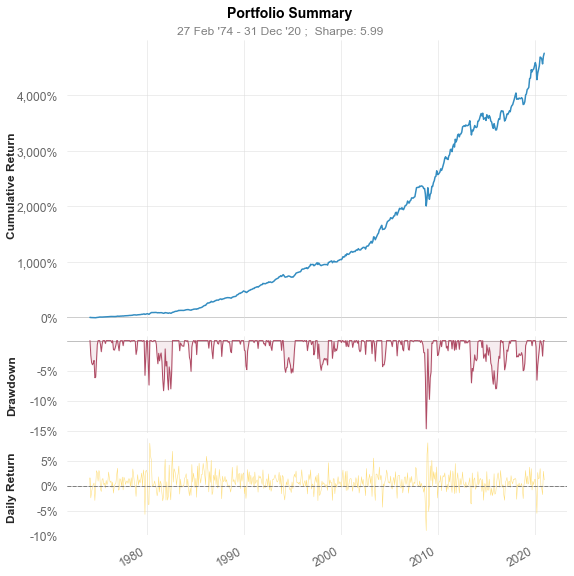

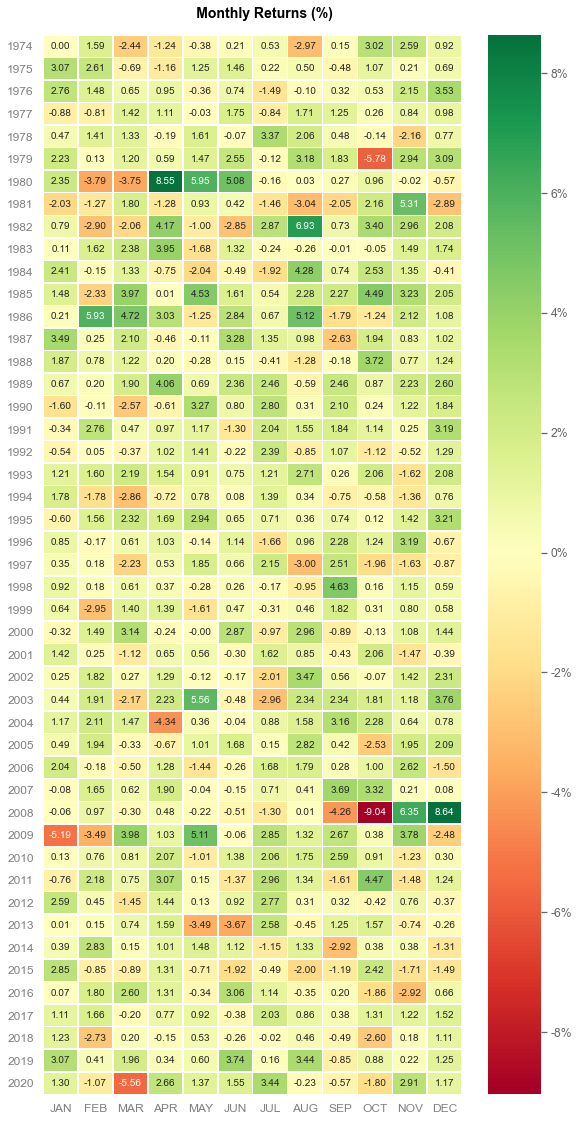

In [43]:
quantstats.reports.plots(RP_Mon_12['RP_Return'], mode='basic')

연 복리 수익률 8.64%, 샤프 비율은 위에서 계산한대로 1.31 (아래 결과는 무시합니다 월간 데이터라 다르게 나옵니다), MDD는 -14.66%입니다. 연간 변동성은 샤프 비율을 보정한 것처럼 하면 6.51%입니다. 비중 고정 All Seasons 전략보다 변동성이 낮아졌고, 이는 target volatility를 설정하고 레버리지를 통해서 수익을 높일 수 있는 원천이 됩니다.

In [44]:
quantstats.reports.metrics(RP_Mon_12['RP_Return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               1974-02-28
End Period                 2020-12-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          4,756.04%
CAGR%                      8.64%
Sharpe                     6.0
Sortino                    11.14
Max Drawdown               -14.66%
Longest DD Days            639
Volatility (ann.)          29.83%
Calmar                     0.59
Skew                       -0.07
Kurtosis                   2.64

Expected Daily %           0.69%
Expected Monthly %         0.69%
Expected Yearly %          8.61%
Kelly Criterion            43.62%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.38%
Expected Shortfall (cVaR)  -2.38%

Payoff Ratio               1.31
Profit Factor              2.79
Common Sense Ratio         4.01
CPC Index                  2.48
Tail Ratio                 1.44
Outlier Win Ratio          3.5
Outlier Loss Ratio        